# CNN approach to pneumonia detection

In this notebook we employ a Convolution Neural Network approach to examine chest radiographs of patients and predict the presence of pneumonia. The original dataset "Chest X-Ray Images" is taken from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia).
<div>
<img src="./Downloads/lungs.jpg" width="500"/>
</div>

## Discription of the dataset

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

The following steps would be taken towards the dataset analysis:
1. Load the data
2. Visualization
3. Data preparation
4. Train the model
5. Analysis of the predictions

## 1. Loading the dataset

We begin by importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import random
import cv2
import os

The following code fetches the images from the subfolders NORMAL and PNEUMONIA of the folders train, val, test and assigns the names of subfolders as corresponding lables

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = [] 
    for i, label in enumerate(labels): 
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                data.append([resized_arr, i])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [5]:
train = get_data('C:/Users/Roman/Downloads/pneumonia/chest_xray/train')
test = get_data('C:/Users/Roman/Downloads/pneumonia/chest_xray/test')
val = get_data('C:/Users/Roman/Downloads/pneumonia/chest_xray/val')

## 2. Visualising the data

Total pneumonia cases in train  = 3883
Total normal cases in train = 1349
Total number of images in train = 5232


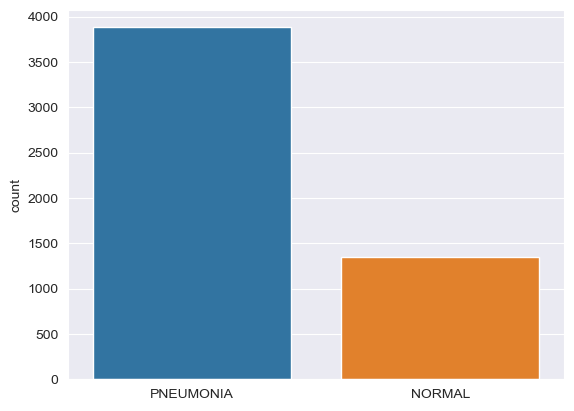

In [6]:
train_labels = [labels[i[1]] for i in train]
sns.set_style('darkgrid')
sns.countplot(x=train_labels) 
print(f"Total pneumonia cases in train  = {train_labels.count('PNEUMONIA')}")
print(f"Total normal cases in train = {train_labels.count('NORMAL')}")
print(f"Total number of images in train = {len(train_labels)}")

We observe that the data is imbalased. Aditionally, the validational set contains only 8 elements. We will add it to the train set and proceed with no validation

In [7]:
train=np.concatenate((train,val))

In [8]:
len(train)

5240

Previewing randomly selected images

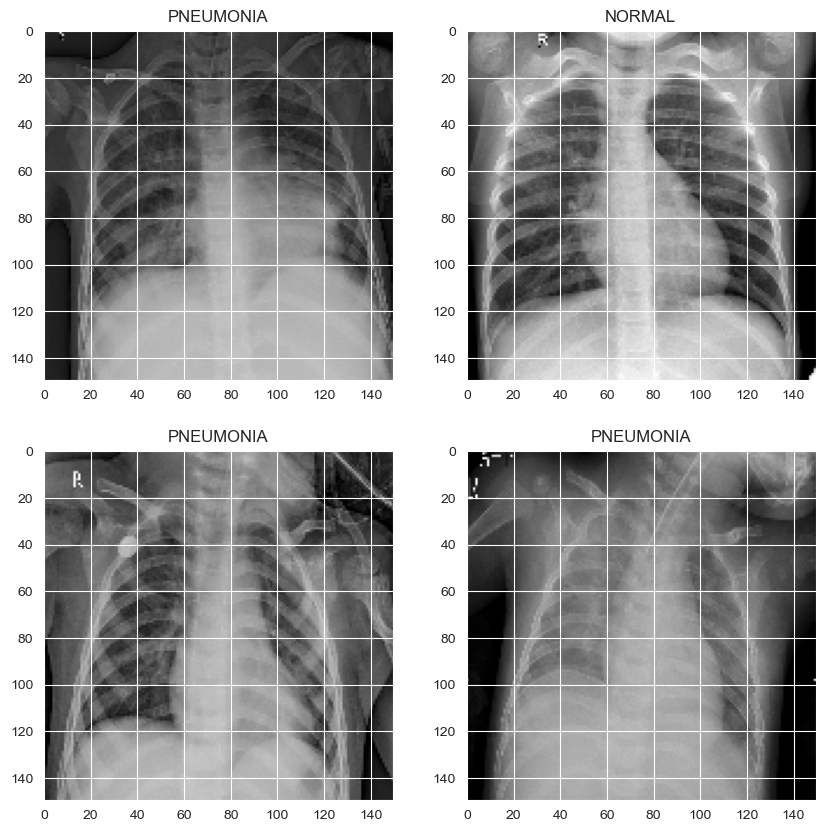

In [9]:
plt.figure(figsize=(10,10))
for i in range(4):
    rn=random.randint(0,len(train))
    plt.subplot(2,2,i+1)
    plt.imshow(train[rn][0], cmap='gray')
    plt.title(labels[train[rn][1]])

## 3. Data preparation

In [10]:
x_train = []
y_train = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

In [11]:
# Normalize the data
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

In [12]:
# Resize data
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

### Data Augmentation
In order to improve the presision of the model and avoid overfitting problem, we need to expand artificially our dataset. We will utilize random rotations, zooms, horizontal and vertical shifts, as well as random horizontal flips of the X-ray images.

In [13]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

dataug = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

dataug.fit(x_train)

## 4. Training the Model

In [3]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
plot_model(model, show_shapes=True, show_layer_names=True)
model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout_4 (Dropout)    

<div>
<img src="./Downloads/net2vis/graph.svg" width="3000"/>
</div>
<div>
<img src="./Downloads/net2vis/legend.svg" width="700"/>
</div>

using [Net2Vis](https://github.com/viscom-ulm/Net2Vis)

In [27]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12)

Epoch 1/12
164/164 [==============================] - 86s 516ms/step - loss: 0.4712 - accuracy: 0.8353
Epoch 2/12
164/164 [==============================] - 86s 524ms/step - loss: 0.2615 - accuracy: 0.9059
Epoch 3/12
164/164 [==============================] - 89s 543ms/step - loss: 0.2253 - accuracy: 0.9176
Epoch 4/12
164/164 [==============================] - 90s 551ms/step - loss: 0.2006 - accuracy: 0.9315
Epoch 5/12
164/164 [==============================] - 88s 539ms/step - loss: 0.1889 - accuracy: 0.9342
Epoch 6/12
164/164 [==============================] - 89s 541ms/step - loss: 0.1668 - accuracy: 0.9420
Epoch 7/12
164/164 [==============================] - 88s 535ms/step - loss: 0.1680 - accuracy: 0.9431
Epoch 8/12
164/164 [==============================] - 84s 513ms/step - loss: 0.1713 - accuracy: 0.9427
Epoch 9/12
164/164 [==============================] - 84s 512ms/step - loss: 0.1689 - accuracy: 0.9414
Epoch 10/12
164/164 [==============================] - 85s 519ms/step - l

## 5. Analysis of the results

In [28]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 91ms/step - loss: 0.3813 - accuracy: 0.9183
Loss of the model is -  0.3813071846961975
20/20 [==============================] - 2s 98ms/step - loss: 0.3813 - accuracy: 0.9183
Accuracy of the model is -  91.82692170143127 %


NameError: name 'history' is not defined

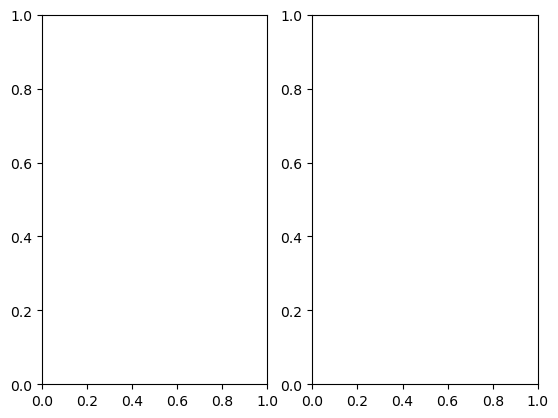

In [5]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].set_title('raining Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [41]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
for i in range(len(predictions)):
    if predictions[i]>=0.5: predictions[i]=1
    else: predictions[i]=0
predictions[:15]

20/20 [==============================] - 2s 92ms/step


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [42]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.90      0.97      0.94       390
   Normal (Class 1)       0.95      0.83      0.88       234

           accuracy                           0.92       624
          macro avg       0.93      0.90      0.91       624
       weighted avg       0.92      0.92      0.92       624



In [20]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

NameError: name 'predictions' is not defined